**Customer value or Customer Lifetime Value** (CLV) 

Is the total monetary value of transactions/purchases made by a customer with your business over his entire lifetime. Here the lifetime means the time period till your customer purchases with you before moving to your competitors.

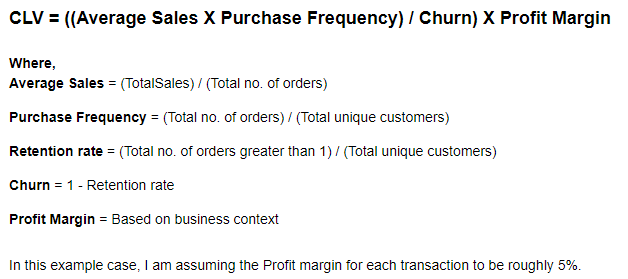

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = r"/content/drive/MyDrive/Sem 4 project/data/raw_online_retail.csv"

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Loading the data
data = pd.read_csv(data_path,encoding="unicode_escape", parse_dates=['InvoiceDate'])
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom


For our Lifetime value calculation, we don't need all the features in this data set. 

We need only the 
**CustomerID, InvoiceDate, Quantity and Total Sales (Quantity * UnitPrice).**
So, we keep only these features and drop all the others.

In [ ]:
# Feature selection
features = ['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice']
data_clv = data[features]
data_clv['TotalSales'] = data_clv['Quantity'].multiply(data_clv['UnitPrice'])
print(data_clv.shape)
data_clv.head()

(541909, 6)


,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,TotalSales
0,17850.0,536365,2010-01-12 08:26:00,6,2.55,15.30
1,17850.0,536365,2010-01-12 08:26:00,6,3.39,20.34
2,17850.0,536365,2010-01-12 08:26:00,8,2.75,22.00
3,17850.0,536365,2010-01-12 08:26:00,6,3.39,20.34
4,17850.0,536365,2010-01-12 08:26:00,6,3.39,20.34


In [ ]:
data_clv.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
TotalSales,541909.0,17.987795,378.810824,-168469.60,3.40,9.75,17.40,168469.6


There are some negative values in the Quantity variable and this is mainly because of returns and that causes the negative values in UnitPrice and TotalSales variable as well. Also, there are some other factors such as discount etc., are also contributing to the negative value in price.

In our Customer Lifetime Value calculation, we are interested only in the total value a customer can generate to the business over his/her lifetime, we can simply drop negative values in Quantity & UnitPrice and work with only positive values.

In [ ]:
data_clv = data_clv[data_clv['TotalSales'] > 0]
data_clv.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,397884.0,15294.423453,1713.141560,12346.000,13969.00,15159.00,16795.00,18287.00
Quantity,530104.0,10.542037,155.524124,1.000,1.00,3.00,10.00,80995.00
UnitPrice,530104.0,3.907625,35.915681,0.001,1.25,2.08,4.13,13541.33
TotalSales,530104.0,20.121871,270.356743,0.001,3.75,9.90,17.70,168469.60


Let's check for missing values in the data and more importantly check for any missing values in the CustomerID variable.

In [ ]:
pd.DataFrame(zip(data_clv.isnull().sum(), data_clv.isnull().sum()/len(data_clv)), columns=['Count', 'Proportion'], index=data_clv.columns)

,Count,Proportion
CustomerID,132220,0.249423
InvoiceNo,0,0.000000
InvoiceDate,0,0.000000
Quantity,0,0.000000
UnitPrice,0,0.000000
TotalSales,0,0.000000


So, clearly we have around 24% missing values in the CustomerID variable.

The main objective of our project is to calculate the lifetime value of each customer. Here each customer is identified by the unique CustomerID.Then How could we able to do that, if we don't have CustomerID in the first place?

So, let's drop the null values in the CustomerID variable.

In [ ]:
# Dropping the null values in the CustomerID variable
data_clv = data_clv[pd.notnull(data_clv['CustomerID'])]
pd.DataFrame(zip(data_clv.isnull().sum(), data_clv.isnull().sum()/len(data_clv)), columns=['Count', 'Proportion'], index=data_clv.columns)

,Count,Proportion
CustomerID,0,0.0
InvoiceNo,0,0.0
InvoiceDate,0,0.0
Quantity,0,0.0
UnitPrice,0,0.0
TotalSales,0,0.0


Finally, all the required cleaning of the data is done. Let's take a look at the final data which we use in our project.

In [ ]:
# Printing the details of the dataset
maxdate = data_clv['InvoiceDate'].dt.date.max()
mindate = data_clv['InvoiceDate'].dt.date.min()
unique_cust = data_clv['CustomerID'].nunique()
tot_quantity = data_clv['Quantity'].sum()
tot_sales = data_clv['TotalSales'].sum()

print(f"The Time range of transactions is: {mindate} to {maxdate}")
print(f"Total number of unique customers: {unique_cust}")
print(f"Total Quantity Sold: {tot_quantity}")
print(f"Total Sales for the period: {tot_sales}")

The Time range of transactions is: 2010-01-12 to 2011-12-10
Total number of unique customers: 4338
Total Quantity Sold: 5167812
Total Sales for the period: 8911407.904


In this example case, I am assuming the Profit margin for each transaction to be roughly 5%.

In [ ]:
# Transforming the data to customer level for the analysis
customer = data_clv.groupby('CustomerID').agg({'InvoiceDate':lambda x: (x.max() - x.min()).days, 
                                                   'InvoiceNo': lambda x: len(x),
                                                  'TotalSales': lambda x: sum(x)})

customer.columns = ['Age', 'Frequency', 'TotalSales']
customer.head()

,Age,Frequency,TotalSales
CustomerID,,,
12346.0,0,1,77183.60
12347.0,475,182,4310.00
12348.0,282,31,1797.24
12349.0,0,73,1757.55
12350.0,0,17,334.40


In [ ]:
# Calculating the necessary variables for CLV calculation
Average_sales = round(np.mean(customer['TotalSales']),2)
print(f"Average sales: ${Average_sales}")

Purchase_freq = round(np.mean(customer['Frequency']), 2)
print(f"Purchase Frequency: {Purchase_freq}")

Retention_rate = customer[customer['Frequency']>1].shape[0]/customer.shape[0]
churn = round(1 - Retention_rate, 2)
print(f"Churn: {churn}%")

Average sales: $2054.27
Purchase Frequency: 91.72
Churn: 0.02%


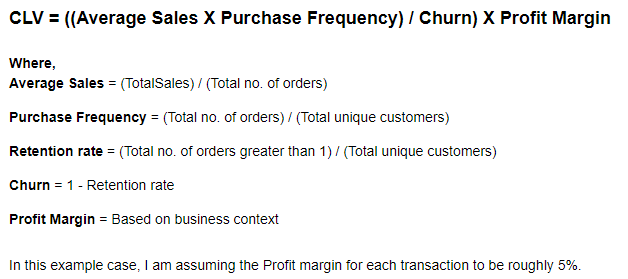

In [ ]:
# Calculating the CLV
Profit_margin = 0.05 

CLV = round(((Average_sales * Purchase_freq/churn)) * Profit_margin, 2)
print(f"The Customer Lifetime Value (CLV) for each customer is: ${CLV}")

The Customer Lifetime Value (CLV) for each customer is: $471044.11


From our basic model, we got a CLV value of $471K for each customer. Do you think this number makes sense? Well it doesn't for me!

The reason is becasue of the very high sales value from very few customers, which actually skewed the overall number. Also, not all the customers are same right!

Take a look at it for yourself:

In [ ]:
customer['TotalSales'].describe()

count      4338.000000
mean       2054.266460
std        8989.230441
min           3.750000
25%         307.415000
50%         674.485000
75%        1661.740000
max      280206.020000
Name: TotalSales, dtype: float64

#Cohort Model
Instead of simply assuming all the customers to be one group, we can try to split them into multiple groups based and calculate the CLV for each group. This model overcomes the major drawback of the simple Aggregate model which assumes the entire customers as a single group. This is called Cohort model.

The main assumption of this model is that, customers within a cohort spend similarly.

The most common way to group customers into cohorts is by the start date of a customer, typically by month. The best choice will depend on the customer acquisition rate, seasonality of business, and whether additional customer information can be used.

In this case, I am grouping them into different cohorts by their start month. So, I will get 12 cohorts of customers (Jan-Dec).

In [ ]:
# Transforming the data to customer level for the analysis
customer = data_clv.groupby('CustomerID').agg({'InvoiceDate':lambda x: x.min().month, 
                                                   'InvoiceNo': lambda x: len(x),
                                                  'TotalSales': lambda x: np.sum(x)})

customer.columns = ['Start_Month', 'Frequency', 'TotalSales']
customer.head()

,Start_Month,Frequency,TotalSales
CustomerID,,,
12346.0,1,1,77183.60
12347.0,7,182,4310.00
12348.0,12,31,1797.24
12349.0,11,73,1757.55
12350.0,2,17,334.40


In [ ]:
# Calculating CLV for each cohort
months = ['Jan', 'Feb', 'March', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
Monthly_CLV = []

for i in range(1, 13):
    customer_m = customer[customer['Start_Month']==i]
    
    Average_sales = round(np.mean(customer_m['TotalSales']),2)
    
    Purchase_freq = round(np.mean(customer_m['Frequency']), 2)
    
    Retention_rate = customer_m[customer_m['Frequency']>1].shape[0]/customer_m.shape[0]
    churn = round(1 - Retention_rate, 2)
    
    CLV = round(((Average_sales * Purchase_freq/churn)) * Profit_margin, 2)
    
    Monthly_CLV.append(CLV)


In [ ]:
monthly_clv = pd.DataFrame(zip(months, Monthly_CLV), columns=['Months', 'CLV'])
monthly_clv

,Months,CLV
0,Jan,1289268.96
1,Feb,485440.81
2,March,887846.81
3,Apr,212539.83
4,May,552802.34
5,Jun,417467.51
6,Jul,352450.58
7,Aug,367128.61
8,Sep,333187.87
9,Oct,264226.95


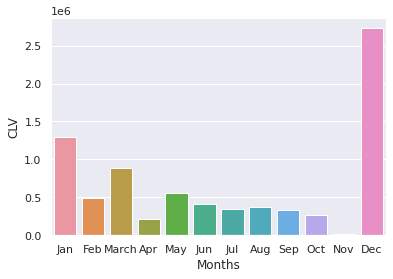

In [ ]:
sns.barplot(x=monthly_clv.Months, y=monthly_clv.CLV)

Now if you look at the result, we have 12 different CLV value for 12 months from Jan-Dec. And it is pretty clear that, customers who are acquired in different months have different CLV values attached to them. This is because, they could be acquired using different campaigns etc., so thier behaviour might be different from others.

Also, if you look at the values for the month of Janaury and December, the CLV values are quite high. This could be a false value, because the data we are using is from a online retails who sell gifts to wholesalers/companies and the festivals like Christmas, Newyear falls on those months. That's why we are seeing a high CLV value for those customers who are started on the month of January and December.

#**Applying Regression Model to Predict Sales of a Customer**

In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
#Extract month and year from InvoiceDate.
data['month_yr'] = data['InvoiceDate'].apply(lambda x: x.strftime('%b-%Y'))
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month_yr
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,Jan-2010
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,Jan-2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,Jan-2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,Jan-2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,Jan-2010


In [ ]:
data['Sales'] = data['Quantity'] * data['UnitPrice']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month_yr,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,Jan-2010,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,Jan-2010,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,Jan-2010,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,Jan-2010,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,Jan-2010,20.34


In [ ]:
sales=data.pivot_table(index=['CustomerID'],columns=['month_yr'],values='Sales',aggfunc='sum',fill_value=0).reset_index()
sales.head()

month_yr,CustomerID,Apr-2011,Aug-2010,Aug-2011,Dec-2010,Dec-2011,Feb-2010,Feb-2011,Jan-2010,Jan-2011,Jul-2010,Jul-2011,Jun-2010,Jun-2011,Mar-2010,Mar-2011,May-2010,May-2011,Nov-2011,Oct-2010,Oct-2011,Sep-2010,Sep-2011
0,12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00
1,12347.0,0.0,0.0,0.0,0.0,0.0,0.0,584.91,0.0,475.39,711.79,861.07,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1294.32,0.0,382.52
2,12348.0,0.0,0.0,0.0,892.8,0.0,0.0,0.00,0.0,227.44,0.00,0.00,0.0,0.0,0.0,0.0,0.0,367.0,0.00,0.0,0.00,0.0,310.00
3,12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1757.55,0.0,0.00,0.0,0.00
4,12350.0,0.0,0.0,0.0,0.0,0.0,0.0,334.40,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00


In [ ]:
sales['Sum_Sales']=sales.iloc[:,2:].sum(axis=1)
sales.head()

month_yr,CustomerID,Apr-2011,Aug-2010,Aug-2011,Dec-2010,Dec-2011,Feb-2010,Feb-2011,Jan-2010,Jan-2011,Jul-2010,Jul-2011,Jun-2010,Jun-2011,Mar-2010,Mar-2011,May-2010,May-2011,Nov-2011,Oct-2010,Oct-2011,Sep-2010,Sep-2011,CLV,Sum_Sales
0,12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00
1,12347.0,0.0,0.0,0.0,0.0,0.0,0.0,584.91,0.0,475.39,711.79,861.07,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1294.32,0.0,382.52,4310.00,8620.00
2,12348.0,0.0,0.0,0.0,892.8,0.0,0.0,0.00,0.0,227.44,0.00,0.00,0.0,0.0,0.0,0.0,0.0,367.0,0.00,0.0,0.00,0.0,310.00,1797.24,3594.48
3,12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1757.55,0.0,0.00,0.0,0.00,1757.55,3515.10
4,12350.0,0.0,0.0,0.0,0.0,0.0,0.0,334.40,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,334.40,668.80


In [ ]:
sales.columns

Index(['CustomerID', 'Apr-2011', 'Aug-2010', 'Aug-2011', 'Dec-2010',
       'Dec-2011', 'Feb-2010', 'Feb-2011', 'Jan-2010', 'Jan-2011', 'Jul-2010',
       'Jul-2011', 'Jun-2010', 'Jun-2011', 'Mar-2010', 'Mar-2011', 'May-2010',
       'May-2011', 'Nov-2011', 'Oct-2010', 'Oct-2011', 'Sep-2010', 'Sep-2011',
       'CLV', 'Sum_Sales'],
      dtype='object', name='month_yr')

**Select latest 6 month as independent variable.**

In [ ]:
imp_features =['Dec-2011','Nov-2011', 'Oct-2011','Sep-2011','Aug-2011','Jul-2011']

In [ ]:
X = sales[imp_features]
y = sales["Sum_Sales"]

In [ ]:
X.shape,y.shape

((4372, 6), (4372,))

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.9559027306216842

In [ ]:
#split training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

from sklearn import metrics

# compute the R Square for model
print("R-Square:",metrics.r2_score(y_test, y_pred))

# calculate MAE using scikit-learn
print("MAE:",metrics.mean_absolute_error(y_test,y_pred))

#calculate mean squared error
print("MSE",metrics.mean_squared_error(y_test, y_pred))

# compute the RMSE of our predictions
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R-Square: 0.9593812261300774
MAE: 1488.9285963827951
MSE 17581359.079006497
RMSE: 4193.013126500619


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Sum_Sales   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                 1.577e+04
Date:                Fri, 28 May 2021   Prob (F-statistic):               0.00
Time:                        15:16:53   Log-Likelihood:                -41602.
No. Observations:                4372   AIC:                         8.322e+04
Df Residuals:                    4365   BIC:                         8.326e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        119.1799     51.391      2.319      0.020      18.428     219.932
Dec-2011       4.1908      0.174     24.133      0.000       3.850       4.531
Nov-2011       2.2528      0.062     36.455      0.000       2.132       2.374
Oct-2011       3.9268      0.074     52.907      0.000       3.781       4.072
Sep-2011       2.2221      0.046     48.721      0.000       2.133       2.312
Aug-2011       6.0634      0.097     62.201      0.000       5.872       6.254
Jul-2011       4.4077      0.071     62.060      0.000       4.268       4.547
==============================================================================
Omnibus:                     6179.636   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9623895.328
Skew:                           7.579   Prob(JB):                         0.00
Kurtosis:                     232.348   Cond. No.                     2.20e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#**Normality Tests For Errors**

Ho(Null Hypothesis) : Errors are not Normally Distributed

H1(Alternate Hypothesis) : Erros are Normally Distributed

In [ ]:
from scipy.stats import shapiro
stat, p = shapiro(results.resid)
print(p)
if p>0.05:
    print("Errors are normally distributed")
    
else:
    print("Errors are not normally distributed")

0.0
Errors are not normally distributed


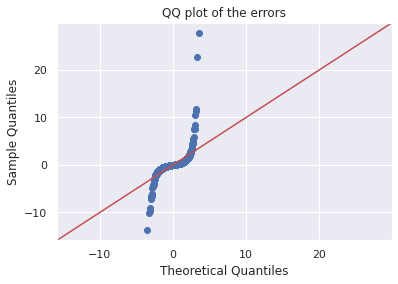

In [ ]:
from statsmodels.graphics.gofplots import ProbPlot
ProbPlot(results.resid, fit=True).qqplot(line = '45')
plt.title('QQ plot of the errors')
plt.show()

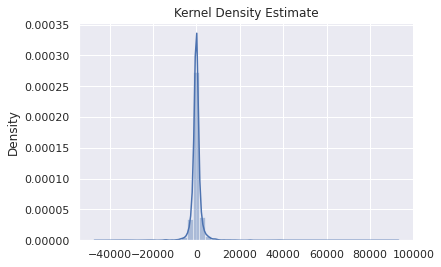

In [ ]:
sns.distplot(results.resid)
plt.title('Kernel Density Estimate')
plt.show()

#**Durbin-Watson_Test for Auto-correlation**

H0 (null hypothesis): There is no correlation among the residuals.

HA (alternative hypothesis): The residuals are autocorrelated.

In [ ]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(results.resid)

2.003060897222922

As a rule of thumb, test statistic of durbin_watson value between the range of 1.5 and 2.5 are considered normal. However, values outside of this range could indicate that autocorrelation is a problem.

So, here in this model we got the test statistic value : 2.003.

Since this is within the range of 1.5 and 2.5, we would consider autocorrelation not to be problematic in this regression model.

#**Test for Heteroscedasticity**

The Null hypothesis (H0): Homoscedasticity is present.

The Nlternative hypothesis: (Ha): Homoscedasticity is not present (i.e. heteroscedasticity exists)

#**Breush-Pagan test:**

In [ ]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

names = ['Lagrange multiplier statistic', 'p-value','f-value', 'f p-value']

test = sms.het_breuschpagan(results.resid, results.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', 1544.8693089880846),
 ('p-value', 0.0),
 ('f-value', 397.5381915883614),
 ('f p-value', 0.0)]

Here 0.0 < 0.05, we reject the null hypothesis

-> Hetero" present

#**Goldfeld-Quandt test**

In [ ]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(results.resid, results.model.exog)
lzip(name, test)

[('F statistic', 0.5841939398032485), ('p-value', 0.9999999999999999)]

Here 0.99 > 0.5, we dont reject the null hypothesis

-> Hetero" not present

#**White test**

In [ ]:
from statsmodels.stats.diagnostic import het_white
# # White Test for Heteroscedasticity, including squares and cross-product of exog
white_test = sms.diagnostic.het_white(results.resid,results.model.exog)

labels = ['Lagrange multiplier statistic', 'p-value','f-value', 'f p-value']
lzip(labels, white_test)

[('Lagrange multiplier statistic', 3274.6081441161546),
 ('p-value', 0.0),
 ('f-value', 480.09110239753727),
 ('f p-value', 0.0)]

Here 0.0 < 0.05, we reject the null hypothesis

-> Hetero" present